* [here](https://github.com/TU-Berlin-DIMA/parallel-ADWIN) is java ADWIN code
* [here](https://github.com/SmileYuhao/concept-drift) is some python code


In [6]:
import os
import tqdm
import pandas as pd
import numpy as np
from collections import Counter
from wasabi import Printer
import nltk
import re
from nltk.corpus import stopwords
import random
from sklearn.tree import DecisionTreeClassifier
import json
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime

from IPython.display import display, Markdown

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from skmultiflow.drift_detection.ddm import DDM
from skmultiflow.drift_detection.eddm import EDDM

In [7]:
eng_stopwords = stopwords.words('english')

In [8]:
working_dir = os.path.abspath('.')
working_dir

'/Users/hamishh/Documents/masters/code/app/fake_data'

In [9]:
MIMIC_path = os.path.abspath('../../../../orion_datascience/FeatureCat/data/raw/NOTEEVENTS.csv')

In [10]:
MIMIC_path

'/Users/hamishh/Documents/orion_datascience/FeatureCat/data/raw/NOTEEVENTS.csv'

In [11]:
data = pd.read_csv(MIMIC_path)
data.head()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [9]:
data = pd.read_csv(MIMIC_path)
data.head()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [10]:
Counter(data['CATEGORY'])

Counter({'Discharge summary': 59652,
         'Echo': 45794,
         'ECG': 209051,
         'Nursing': 223556,
         'Physician ': 141624,
         'Rehab Services': 5431,
         'Case Management ': 967,
         'Respiratory ': 31739,
         'Nutrition': 9418,
         'General': 8301,
         'Social Work': 2670,
         'Pharmacy': 103,
         'Consult': 98,
         'Radiology': 522279,
         'Nursing/other': 822497})

In [4]:
def get_category_sample(category, n_samples=False):
    cat = data[ data['CATEGORY']==category ]
    if n_samples:
        cat = cat.sample(n=n_samples)
    return list( cat['TEXT'] )

In [12]:
rad = get_category_sample('Radiology')
len(rad)

522279

In [16]:
sample = get_category_sample('Radiology', 1)[0]
sample

'[**2107-3-29**] 7:34 AM\n CHEST (PORTABLE AP)                                             Clip # [**Clip Number (Radiology) 29963**]\n Reason: Please assess for any new infiltrates.\n ______________________________________________________________________________\n [**Hospital 3**] MEDICAL CONDITION:\n    [**Age over 90 **] year old man with sob, CABG, with witnessed aspiration, has new onset\n  fever.\n REASON FOR THIS EXAMINATION:\n  Please assess for any new infiltrates.\n ______________________________________________________________________________\n                                 FINAL REPORT\n CHEST:\n\n INDICATION:  SOB, witnessed aspiration.  New onset fever.  CABG surgery.\n Check for pulmonary infiltrates.\n\n FINDINGS:  A single AP upright image is provided.  Comparison study dated\n [**2107-3-28**].  There is moderate left ventricular enlargement of the heart.  Status\n post CABG surgery noted, with sternal sutures, cardiovascular clips and\n anastomotic loops noted.  Som

In [13]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [47]:
re.match(r'(.*)(\_){78}\s+(.*)', sample, flags=re.DOTALL).groups()

('[**2107-3-29**] 7:34 AM\n CHEST (PORTABLE AP)                                             Clip # [**Clip Number (Radiology) 29963**]\n Reason: Please assess for any new infiltrates.\n ______________________________________________________________________________\n [**Hospital 3**] MEDICAL CONDITION:\n    [**Age over 90 **] year old man with sob, CABG, with witnessed aspiration, has new onset\n  fever.\n REASON FOR THIS EXAMINATION:\n  Please assess for any new infiltrates.\n ',
 '_',
 'FINAL REPORT\n CHEST:\n\n INDICATION:  SOB, witnessed aspiration.  New onset fever.  CABG surgery.\n Check for pulmonary infiltrates.\n\n FINDINGS:  A single AP upright image is provided.  Comparison study dated\n [**2107-3-28**].  There is moderate left ventricular enlargement of the heart.  Status\n post CABG surgery noted, with sternal sutures, cardiovascular clips and\n anastomotic loops noted.  Some residual ill-defined pulmonary infiltrates are\n noted bilaterally in a pericentral distribution, m

In [69]:
from nltk.corpus import stopwords
en_sw = stopwords.words('english')

In [92]:
if re.search('\*Hospital (\d+)\*', sample):
    print('hello')

hello


In [97]:
def doc2df(doc):
    match = re.match(r'(.*)(\_){78}\s+(.*)', sample, flags=re.DOTALL)
    head = match.group(1)
    body = match.group(3)
    
    #####################################
    ##### Header Content            #####
    #####################################
    
    # Age
    age_match = re.match('year old (\w+)', head)
    if age_match:
        age = int(age.group(1)) // 10
        age = str(age) + 's'
    elif 'Age over 90' in head:
        age = '90s'
    else:
        print('cannot find age')
        print(head)
        
    
    # Gender
    if "man" in head:
        gender = "male"
    elif "woman" in head:
        gender = "female"
    else:
        print("no gender found for:")
        print(head)
        gender = "female"
    
    # Hospital
    hosp_match = re.search('\*Hospital (\d+)\*', head)
    if hosp_match:
        hospital = hosp_match.group(1)
    else:
        print('cannot find hospital')
        print(head)
    
    #####################################
    ##### Body Content              #####
    #####################################
    body = [ token.lemma_ for token in nlp(body) ]
    body = [ token for token in body if token.isalpha() and token not in en_sw ]
    return head, body

In [96]:
doc2df(sample)

('[**2107-3-29**] 7:34 AM\n CHEST (PORTABLE AP)                                             Clip # [**Clip Number (Radiology) 29963**]\n Reason: Please assess for any new infiltrates.\n ______________________________________________________________________________\n [**Hospital 3**] MEDICAL CONDITION:\n    [**Age over 90 **] year old man with sob, CABG, with witnessed aspiration, has new onset\n  fever.\n REASON FOR THIS EXAMINATION:\n  Please assess for any new infiltrates.\n ',
 ['final',
  'report',
  'chest',
  'indication',
  'sob',
  'witness',
  'aspiration',
  'new',
  'onset',
  'fever',
  'cabg',
  'surgery',
  'check',
  'pulmonary',
  'infiltrate',
  'findings',
  'single',
  'ap',
  'upright',
  'image',
  'provide',
  'comparison',
  'study',
  'date',
  'moderate',
  'left',
  'ventricular',
  'enlargement',
  'heart',
  'status',
  'post',
  'cabg',
  'surgery',
  'note',
  'sternal',
  'suture',
  'cardiovascular',
  'clip',
  'anastomotic',
  'loop',
  'note',
  'resi

In [12]:
sample = get_category_sample('Radiology', 2000)

msg = Printer()
for i in range(4):
    msg.divider(f'Sample {i}')
    print(sample[i])


================================== Sample 0 ==================================
[**2172-4-15**] 9:13 AM
 ABDOMEN U.S. (COMPLETE STUDY); -59 DISTINCT PROCEDURAL SERVICE  Clip # [**Clip Number (Radiology) 9497**]
 DUPLEX DOPP ABD/PEL
 Reason: evaluate portal system with dopplers and for lesions; evalau
 Admitting Diagnosis: LIVER FAILURE
 ______________________________________________________________________________
 [**Hospital 2**] MEDICAL CONDITION:
  67 year old woman with worsening autoimmune hepatitis
 REASON FOR THIS EXAMINATION:
  evaluate portal system with dopplers and for lesions; evalaute for ascites
 ______________________________________________________________________________
 WET READ: ENYa WED [**2172-4-15**] 12:16 PM
  1. Major intrahepatic vessels patent with normal antegrade flow.
  2. Coarsened hepatic echotexture, compatible with the known autoimmune
  hepatitis.
  3. No focal hepatic lesion.  No ascites.  S/p cholecystectomy.
 WET READ VERSION #1
 _________________

In [13]:
# Extra cols
ethnicity_options = ['european', 'asian', 'polynesian', 'african', 'innuit']
sex_options = ['female', 'male']
name_options = ['John Yossarian', 'A. T. Tappman', 'Major Major Major', 'Chuck Cathcart', 'Milo Minderbinder',
       'Dr. Dan Daneeka', 'Major —— de Coverley', 'Hungry Joe', 'General P P Peckem',
       'Chief White Halfoat ', 'Ex-P.F.C. Wintergreen']
age_options = ['40-49', '50-59', '60-69', '70-79', '80-89', '90-99']

In [14]:
def parse_datetime(text):
    mat = re.match('\[\*\*[\d-]+\*\*\] \d+:\d+ [AP]M', text)
    if mat:
        return datetime.strptime(mat.group(0), '[**%Y-%m-%d**] %I:%M %p')
    mat = re.findall('\[\*\*[\d-]+\*\*\] at \d+:\d+', text)
    if mat: # [**2150-4-7**] at 11:57
        return datetime.strptime(mat[0], '[**%Y-%m-%d**] at %H:%M')
    return None

def create_readable_dataset(samples):
    
    dataset_readable = pd.DataFrame()
    
    dataset_readable['date'] = [ parse_datetime(sample) for sample in samples ]
    
    for col_name in ['name', 'ethnicity', 'sex', 'age']:
        options = eval(col_name + '_options')
        dataset_readable[col_name] = random.choices(options, k=len(samples))
        
    dataset_readable['text'] = samples
    
    dataset_readable.dropna(inplace=True)
    
    return dataset_readable

dataset_readable = create_readable_dataset(sample)
dataset_readable.head()

,date,name,ethnicity,sex,age,text
0,2172-04-15 09:13:00,Ex-P.F.C. Wintergreen,asian,male,40-49,[**2172-4-15**] 9:13 AM\n ABDOMEN U.S. (COMPLE...
1,2150-05-14 14:36:00,Dr. Dan Daneeka,innuit,female,90-99,[**2150-5-14**] 2:36 PM\n CHEST (PORTABLE AP) ...
2,2185-11-30 13:00:00,John Yossarian,european,male,80-89,[**2185-11-30**] 1:00 PM\n CHEST (PRE-OP PA & ...
3,2174-08-22 08:56:00,Major Major Major,european,male,60-69,[**2174-8-22**] 8:56 AM\n BX-NEEDLE KIDNEY BY ...
4,2147-06-06 11:03:00,John Yossarian,european,female,80-89,[**2147-6-6**] 11:03 AM\n MR HEAD W & W/O CONT...


In [15]:
def texts_to_wordlists(texts):
    
    sample_word_lists = [ [ re.sub('[^a-z]', '', word.lower()) for word
                          in nltk.tokenize.word_tokenize(text) ]
                         for text in texts ]

    sample_word_lists = [ [ word for word in sample if len(word) > 0 and word not in eng_stopwords]
                         for sample in sample_word_lists ]
    
    return sample_word_lists

In [16]:
sample_word_lists = texts_to_wordlists(sample)

word_ctr = Counter([ word for sample in sample_word_lists for word in sample ])
word_ctr.most_common(10)

[('clip', 4377),
 ('reason', 4337),
 ('right', 3791),
 ('left', 3382),
 ('chest', 3126),
 ('contrast', 2402),
 ('report', 2384),
 ('radiology', 2312),
 ('examination', 2296),
 ('final', 2283)]

In [17]:
# # inverse document frequency of each word
# idf = { word: len(sample_word_lists) / len([doc for doc in sample_word_lists if word in doc])  
#        for (word, count) in word_ctr.items() if count >= 5 }
# words_by_idf = sorted(vocab, key=lambda x: idf[x])
# words_by_idf[:10]

In [18]:
vocab = [ word for (word, count) in word_ctr.most_common(100) ]

In [19]:
def create_dataset(readable_dataset):
    
    dataset = pd.DataFrame({'date': readable_dataset['date']})

    for categorical in ['ethnicity', 'sex', 'age']:
        for value in eval(categorical + '_options'):
            dataset[value] = readable_dataset[categorical].apply(lambda x: x==value)

    for word in vocab:
        dataset[word] = [ word in sample for sample in 
                         texts_to_wordlists(readable_dataset['text']) ]
        
    return dataset

dataset = create_dataset(dataset_readable)
dataset.sort_values('date', inplace=True)
dataset.reset_index(drop=True, inplace=True)
dataset.head()

,date,european,asian,polynesian,african,innuit,female,male,40-49,50-59,...,position,effusions,fracture,mm,identified,likely,view,picc,compared,air
0,2100-07-06 08:55:00,False,False,True,False,False,False,True,True,False,...,True,False,False,False,False,False,False,True,False,False
1,2100-07-27 01:12:00,False,False,True,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
2,2100-08-27 10:58:00,False,True,False,False,False,False,True,True,False,...,False,False,False,False,True,False,False,False,True,False
3,2100-10-01 16:53:00,False,False,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2100-10-02 21:02:00,True,False,False,False,False,True,False,False,True,...,False,False,False,False,True,False,False,False,True,False


In [20]:
len(dataset)

1905

In [22]:
dataset.to_csv('synthetic.csv', index=False)

In [64]:
sample2 = get_category_sample('Echo', 1000)

msg = Printer()
for i in range(4):
    msg.divider(f'Sample {i}')
    print(sample2[i])


================================== Sample 0 ==================================
PATIENT/TEST INFORMATION:
Indication: Atrial fibrillation. Left ventricular function. Preoperative assessment
Height: (in) 72
Weight (lb): 162
BSA (m2): 1.95 m2
BP (mm Hg): 112/64
HR (bpm): 83
Status: Inpatient
Date/Time: [**2196-6-9**] at 10:44
Test: Portable TTE (Complete)
Doppler: Full Doppler and color Doppler
Contrast: None
Technical Quality: Suboptimal


INTERPRETATION:

Findings:

LEFT ATRIUM: Mild LA enlargement.

RIGHT ATRIUM/INTERATRIAL SEPTUM: Mildly dilated RA.

LEFT VENTRICLE: Normal LV wall thickness. Normal LV cavity size. Mildly
depressed LVEF. No resting LVOT gradient.

LV WALL MOTION: Regional LV wall motion abnormalities include: basal inferior
- hypo; mid inferior - hypo; basal inferolateral - hypo; mid inferolateral -
hypo; apex - hypo;

RIGHT VENTRICLE: Normal RV free wall thickness. Mildly dilated RV cavity. RV
function depressed.

AORTA: Mildy dilated aortic root. Focal calcification

In [71]:
parse_datetime(sample2[0])

In [94]:
dataset2 = create_readable_dataset(sample2)

,date,name,ethnicity,sex,age,text
0,2196-06-09 10:44:00,Hungry Joe,asian,male,80-89,PATIENT/TEST INFORMATION:\nIndication: Atrial ...
1,2105-06-05 13:00:00,A. T. Tappman,european,male,70-79,PATIENT/TEST INFORMATION:\nIndication: CAD\n...
2,2193-02-05 14:47:00,General P P Peckem,european,female,80-89,PATIENT/TEST INFORMATION:\nIndication: Aortic ...
3,2110-04-07 16:07:00,Major Major Major,african,female,70-79,PATIENT/TEST INFORMATION:\nIndication: Pericar...
4,2157-03-14 11:36:00,A. T. Tappman,european,male,70-79,PATIENT/TEST INFORMATION:\nIndication: Chemoth...


In [95]:
dataset2 = create_dataset(dataset2)
dataset2.sort_values('date', inplace=True)
dataset2.head()

,date,european,asian,polynesian,african,innuit,female,male,40-49,50-59,...,heart,pneumonia,compared,mass,likely,unremarkable,air,ro,also,lateral
897,2100-09-07 17:17:00,False,False,True,False,False,False,True,True,False,...,False,False,True,False,True,False,False,False,False,False
92,2100-10-01 13:50:00,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
163,2100-11-05 12:05:00,False,False,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
848,2101-02-08 11:00:00,False,False,False,True,False,True,False,False,True,...,True,False,False,False,False,False,False,False,False,True
682,2101-02-11 15:04:00,False,False,True,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,True


# Create concepts

In [112]:
def make_concept(data, i=1):
    # I don't remember what i does.
    
    data = data.drop('date', 1)
    
    dtree = DecisionTreeClassifier()
    n_subsamples = 10
    dtree.fit(data.sample(n_subsamples), np.random.randint(1, 6, size=n_subsamples))

    dot_data = StringIO()
    export_graphviz(dtree, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    
    display(Markdown(f'### Concept {i}'))
    display((Image(graph.create_png())))

    split_features = [ i for i in dtree.tree_.feature if i >= 0 ]
    print(f'Split features: {list(dataset.columns[split_features])}')
    
    return dtree

In [113]:
def add_labels(data, concept):
    labels = concept.predict(data.drop('date', 1))
    ret = data.copy()
    ret['label'] = labels
    return ret

# Scenario 1: Real Drift

In [121]:
np.std([1,2,3,4])

1.118033988749895

In [239]:
beta = 0.99

label_classes = [1,2,3,4,5]

def get_ewma_stream(seq):
    ret = []
    mt = 0
    for t, val in enumerate(seq):
        mt = beta*mt + (1-beta)*val
        mt_hat = mt / (1-beta**(t+1)) # bias correction
        ret.append(mt_hat)
    return np.array(ret)

def get_stream_df(train, data):
    
    # Create the dataframe
    data.reset_index(drop=True, inplace=True)
    results = pd.DataFrame({'date': data['date'], 
                            'warning_level': np.zeros(len(data)), 
                            'drift_level': np.zeros(len(data)), 
                            'error_rate': np.zeros(len(data))})
    data.drop('date', 1, inplace=True)

    # Get the error stream
    model = BernoulliNB()
    model.partial_fit(train.loc[:, train.columns != 'label'], 
                      train.loc[:, 'label'], classes=label_classes)
    predictions = model.predict(data.loc[:, train.columns != 'label'])
    errors = list( predictions != data['label'] )

    # Add the error rate, etc to the df
    ddm = DDM()
    for i, error in enumerate(errors):
        # Update DDM
        ddm.add_element(error)

        warning_level = ddm.miss_prob_min + ddm.warning_level * ddm.miss_sd_min
        drift_level = ddm.miss_prob_min + ddm.out_control_level * ddm.miss_sd_min
        error_rate = ddm.miss_prob + ddm.miss_std

        results.loc[i, 'warning_level'] = warning_level
        results.loc[i, 'drift_level'] = drift_level
        results.loc[i, 'error_rate'] = error_rate
        
    # Get the label streams
    for label in label_classes:
        label_stream = data['label'] == label
        results[f'label={label}'] = get_ewma_stream(label_stream)
        
    # Get the feature streams
    for col in train.columns:
        if col == 'label':
            continue
        mean = np.mean(train[col])
        std = np.std(train[col])
        if std == 0:
            print(f'{col} has std of 0')
            std = 0.1
        ewma_stream = get_ewma_stream(data[col])
        results[col] = (ewma_stream - mean) / std

    # drop the first 30 instances while the thing calibrates
    results = results[30:]
    
    return results

### Concept 1

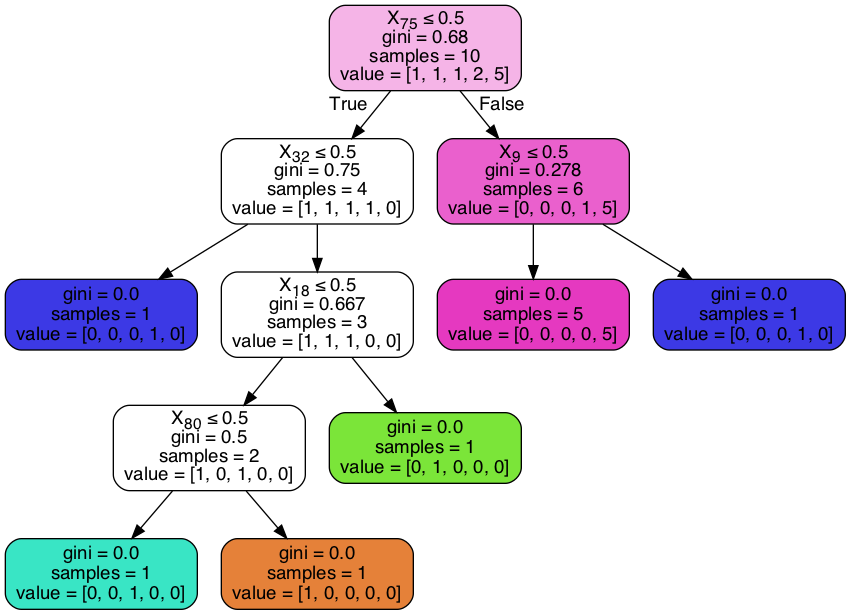

Split features: ['catheter', 'pm', 'chest', 'images', '50-59']


### Concept 2

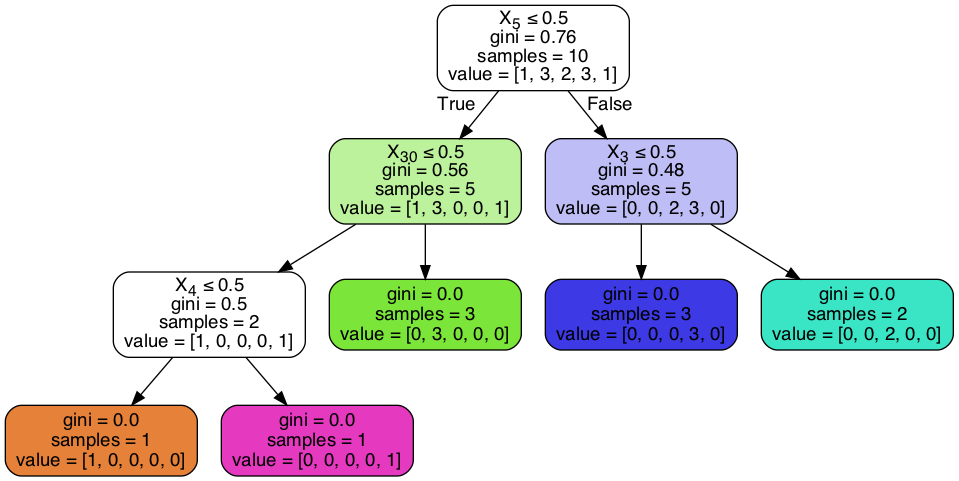

Split features: ['innuit', 'old', 'african', 'polynesian']


In [240]:
# Generate some concepts
c1 = make_concept(dataset, 1)
c2 = make_concept(dataset, 2)

In [241]:
# Scenario specs
training_examples = 500
drift_at = 1000
end = 1500

# Generate the data
train = add_labels(dataset[:training_examples], c1)
train.drop('date', 1, inplace=True)
d1 = add_labels(dataset[training_examples:drift_at], c1)
d2 = add_labels(dataset[drift_at:end], c2)
data = pd.concat([d1, d2])

scenario1 = get_stream_df(train, data)
scenario1.head()

reason has std of 0
report has std of 0
final has std of 0


,date,warning_level,drift_level,error_rate,label=1,label=2,label=3,label=4,label=5,european,...,heart,pneumonia,compared,mass,likely,unremarkable,air,ro,also,lateral
30,2130-09-01 16:06:00,0.346059,0.419089,0.300902,0.059031,0.125111,0.257520,0.370953,0.187385,0.042916,...,-0.087711,0.107985,-0.231728,-0.100849,0.080814,0.019986,0.062953,0.583113,-0.010518,0.057448
31,2130-09-04 13:22:00,0.346059,0.419089,0.291829,0.056885,0.120562,0.248156,0.393826,0.180571,0.023403,...,-0.104507,0.087254,-0.242950,-0.111113,0.061771,0.001878,0.044442,0.550198,-0.027975,0.038438
32,2130-09-13 14:59:00,0.346059,0.419089,0.283286,0.054870,0.116290,0.239365,0.379874,0.209601,0.005082,...,-0.120276,0.067790,-0.253487,-0.120750,0.139569,0.075924,0.027062,0.519295,0.045227,0.020591
33,2130-09-22 15:09:00,0.346059,0.419089,0.275227,0.052974,0.112273,0.231095,0.366750,0.236909,0.074879,...,-0.135109,0.049481,-0.263398,-0.129815,0.119445,0.056786,0.010714,0.490226,0.026715,0.003802
34,2130-10-21 09:13:00,0.346059,0.419089,0.299550,0.051188,0.108487,0.257023,0.354382,0.228920,0.140651,...,-0.149087,0.032228,-0.272737,-0.037424,0.100482,0.125414,-0.004692,0.462833,0.094547,-0.012018


In [242]:
scenario1.to_csv('scenario1.csv', index=False)

In [243]:
test = pd.read_csv('scenario1.csv')
test.head()

,date,warning_level,drift_level,error_rate,label=1,label=2,label=3,label=4,label=5,european,...,heart,pneumonia,compared,mass,likely,unremarkable,air,ro,also,lateral
0,2130-09-01 16:06:00,0.346059,0.419089,0.300902,0.059031,0.125111,0.257520,0.370953,0.187385,0.042916,...,-0.087711,0.107985,-0.231728,-0.100849,0.080814,0.019986,0.062953,0.583113,-0.010518,0.057448
1,2130-09-04 13:22:00,0.346059,0.419089,0.291829,0.056885,0.120562,0.248156,0.393826,0.180571,0.023403,...,-0.104507,0.087254,-0.242950,-0.111113,0.061771,0.001878,0.044442,0.550198,-0.027975,0.038438
2,2130-09-13 14:59:00,0.346059,0.419089,0.283286,0.054870,0.116290,0.239365,0.379874,0.209601,0.005082,...,-0.120276,0.067790,-0.253487,-0.120750,0.139569,0.075924,0.027062,0.519295,0.045227,0.020591
3,2130-09-22 15:09:00,0.346059,0.419089,0.275227,0.052974,0.112273,0.231095,0.366750,0.236909,0.074879,...,-0.135109,0.049481,-0.263398,-0.129815,0.119445,0.056786,0.010714,0.490226,0.026715,0.003802
4,2130-10-21 09:13:00,0.346059,0.419089,0.299550,0.051188,0.108487,0.257023,0.354382,0.228920,0.140651,...,-0.149087,0.032228,-0.272737,-0.037424,0.100482,0.125414,-0.004692,0.462833,0.094547,-0.012018


# Scenario 2: Virtual Drift

In [244]:
d2 = add_labels(dataset2[:500], c1)
d2['date'] = list(dataset.loc[drift_at:end-1, 'date']) # I don't understand why it needs to be like this, but it's the only way I've gotten it to work.
data = pd.concat([d1, d2], sort=False)
scenario2 = get_stream_df(train, data)
scenario2.head()

reason has std of 0
report has std of 0
final has std of 0


,date,warning_level,drift_level,error_rate,label=1,label=2,label=3,label=4,label=5,european,...,heart,pneumonia,compared,mass,likely,unremarkable,air,ro,also,lateral
30,2130-09-01 16:06:00,0.346059,0.419089,0.300902,0.059031,0.125111,0.257520,0.370953,0.187385,0.042916,...,-0.087711,0.107985,-0.231728,-0.100849,0.080814,0.019986,0.062953,0.583113,-0.010518,0.057448
31,2130-09-04 13:22:00,0.346059,0.419089,0.291829,0.056885,0.120562,0.248156,0.393826,0.180571,0.023403,...,-0.104507,0.087254,-0.242950,-0.111113,0.061771,0.001878,0.044442,0.550198,-0.027975,0.038438
32,2130-09-13 14:59:00,0.346059,0.419089,0.283286,0.054870,0.116290,0.239365,0.379874,0.209601,0.005082,...,-0.120276,0.067790,-0.253487,-0.120750,0.139569,0.075924,0.027062,0.519295,0.045227,0.020591
33,2130-09-22 15:09:00,0.346059,0.419089,0.275227,0.052974,0.112273,0.231095,0.366750,0.236909,0.074879,...,-0.135109,0.049481,-0.263398,-0.129815,0.119445,0.056786,0.010714,0.490226,0.026715,0.003802
34,2130-10-21 09:13:00,0.346059,0.419089,0.299550,0.051188,0.108487,0.257023,0.354382,0.228920,0.140651,...,-0.149087,0.032228,-0.272737,-0.037424,0.100482,0.125414,-0.004692,0.462833,0.094547,-0.012018


In [245]:
scenario2.tail()

,date,warning_level,drift_level,error_rate,label=1,label=2,label=3,label=4,label=5,european,...,heart,pneumonia,compared,mass,likely,unremarkable,air,ro,also,lateral
995,2180-10-05 21:00:00,0.397882,0.431901,0.368654,0.000736,0.335662,0.001718,0.607180,0.054704,-0.064834,...,-0.170461,-0.459171,0.594939,-0.169512,-0.108747,-0.474333,-0.443232,-0.235294,-0.419844,-0.169985
996,2180-10-20 13:58:00,0.397882,0.431901,0.366835,0.000729,0.332305,0.001701,0.611108,0.054157,-0.069123,...,-0.174253,-0.459201,0.583586,-0.171648,-0.112089,-0.474370,-0.443261,-0.236162,-0.420552,-0.172939
997,2180-11-26 12:54:00,0.397882,0.431901,0.365033,0.000722,0.328982,0.001684,0.614997,0.053615,-0.073370,...,-0.178007,-0.459230,0.596257,-0.173763,-0.088389,-0.474406,-0.443289,-0.237021,-0.421252,-0.175863
998,2180-11-30 14:26:00,0.396498,0.429747,0.363249,0.000715,0.325692,0.001667,0.618847,0.053079,-0.052382,...,-0.181723,-0.459259,0.584890,-0.175857,-0.091935,-0.474442,-0.443318,-0.237872,-0.421946,-0.152614
999,2180-12-20 18:07:00,0.394607,0.427731,0.361482,0.000707,0.322435,0.001650,0.612659,0.062549,-0.056795,...,-0.161711,-0.459288,0.573637,-0.177930,-0.095445,-0.474478,-0.443346,-0.238715,-0.422632,-0.129597


In [246]:
scenario2.to_csv('scenario2.csv', index=False)

# Old test

In [96]:
change_points = [0, 500, 1000, 2000, 4000, 8000, len(dataset)] # list must start with zero and end with len(dataset)

y = []

for i, cp in enumerate(change_points[:-1]):
    y.extend( concepts[i].predict(dataset[cp: change_points[i+1]]) )
    
    # measure how different this concept is from the next
    if i==0:
        continue
    y_this = concepts[i].predict(dataset[cp: change_points[i+1]])
    y_prev = concepts[i-1].predict(dataset[cp: change_points[i+1]])
    print(i, len([i for i in range(len(y_this)) if y_this[i]==y_prev[i]])/len(y_this))

print('mean priority', np.mean(y))

1 0.272
2 0.32
3 0.273
4 0.222
5 0.30325
mean priority 2.441


# Predictions

In [97]:
import warnings
warnings.filterwarnings('ignore')

In [98]:
dataset.head()

,female,male,european,asian,polynesian,african,innuit,report,reason,clip,...,approximately,free,two,anterior,internal,carina,aorta,lesions,amount,midline
0,True,False,False,True,False,False,False,True,True,True,...,False,False,False,False,False,False,False,False,True,False
1,True,False,False,True,False,False,False,True,True,True,...,False,False,False,True,False,False,False,False,False,False
2,False,False,False,False,False,True,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,True,True,True,True,...,True,True,False,True,False,False,False,True,False,False
4,False,False,False,True,False,False,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False


In [114]:
from tqdm import tqdm

In [119]:
feature_streams = {col:[] for col in dataset.columns}

for i in tqdm(range(1, 1000)):
    for col in dataset.columns:
        feature_streams[col].append( dataset[:i][col].mean() )
        
feature_streams = {i:(list(range(len(stream))), stream) for i, stream in feature_streams.items()}

with open('feature_streams.json', 'w') as f:
    f.write(json.dumps(feature_streams))

100%|██████████| 999/999 [00:48<00:00, 19.89it/s]


In [117]:
label_streams = {i:[] for i in [1,2,3,4,5]}
label_counts = [0 for i in [1,2,3,4,5]]

for i in range(1, len(dataset)-1):
    y_ = y[i]
    label_counts[y_-1] += 1
    props = np.array(label_counts) / np.sum(label_counts)
    for i in range(len(label_streams)):
        label_streams[i+1].append(props[i])
        
label_streams = {i:(list(range(len(stream))), stream) for i, stream in label_streams.items()}
        
with open('label_streams.json', 'w') as f:
    f.write(json.dumps(label_streams))

In [102]:
model = BernoulliNB()
model.partial_fit(dataset[0: 0+1], y[0: 0+1], classes=[1,2,3,4,5])

ddm = DDM()

res_list = []
warning_list = []
drift_list = []

current_list = []

x_buffer = dataset[:0]
y_buffer = []

detection_list = []

feature_streams = {col:[] for col in dataset.columns}

for i in range(1, len(dataset)-1):
    
    y_ = y[i: i+1]
    x_ = dataset[i: i+1]
    
#     for col in dataset.columns:
#         feature_streams[col].append( dataset[:i+1][col].mean() )
    
    y_hat = model.predict(x_)
    res = bool(y_ != y_hat) # residual
    res_list.append(res)
    
    model = model.partial_fit(x_, y_)
    
    # Update DDM
    ddm.add_element(res)
    
    warning_level = ddm.miss_prob_min + ddm.warning_level * ddm.miss_sd_min
    drift_level = ddm.miss_prob_min + ddm.out_control_level * ddm.miss_sd_min
    
    current_level = ddm.miss_prob + ddm.miss_std
    
    warning_list.append(warning_level)
    drift_list.append(drift_level)
    current_list.append(current_level)
    
    # Check for drift/warning
    if ddm.detected_warning_zone():
        if not prev_warning:
            # reset buffer
            x_buffer = dataset[:0]
            y_buffer = []
        x_buffer = x_buffer.append(dataset.iloc[i])
        y_buffer.append(y[i])
    else:
        prev_warning = False
        
    if ddm.detected_change():
        model = BernoulliNB()
        model.partial_fit(x_buffer, y_buffer, classes=[1,2,3,4,5])
        ddm.reset()
        detection_list.append(i)
    
np.mean(res_list)

0.16771677167716773

In [103]:
lists = {'accuracy': current_list,
         'warning level': warning_list,
         'drift level': drift_list}

for list_name, list_ in lists.items():
    lists[list_name] = ( [ i for i in range(len(list_)) if np.isfinite(list_[i]) ],
                         [ i for i in list_ if np.isfinite(i) ]
                       )

with open('data_streams.json', 'w') as f:
    f.write(json.dumps(lists))

NameError: name 'feature_steams' is not defined